# Feature selection / Dimensionality reduction
Feature selection involves picking the set of features that are most relevant to the target variable. This helps in reducing the complexity of your model, as well as minimizing the resources required for training and inference. This has greater effect in production models where you maybe dealing with terabytes of data or serving millions of requests.

There are multiple ways to select the most important features for our model. In the sections below we will go through a couple of them to see if they can improve the model performance

In [1]:
# Imports
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

pd.set_option('max.rows', 100)
pd.set_option('max.columns', 100)

sns.set()

## Load data
Let's load the data at do some initial investigation

In [2]:
# Data path
DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data/klarna/train/train.csv'))

# Load data
df = pd.read_csv(DATA_PATH)

# Print datatypes
print(df.dtypes)

# Describe columns
df.describe(include='all').T

uuid                                    object
default                                  int64
account_amount_added_12_24m              int64
account_days_in_dc_12_24m              float64
account_days_in_rem_12_24m             float64
account_days_in_term_12_24m            float64
account_incoming_debt_vs_paid_0_24m    float64
account_status                         float64
account_worst_status_0_3m              float64
account_worst_status_12_24m            float64
account_worst_status_3_6m              float64
account_worst_status_6_12m             float64
age                                      int64
avg_payment_span_0_12m                 float64
avg_payment_span_0_3m                  float64
merchant_category                       object
merchant_group                          object
has_paid                                  bool
max_paid_inv_0_12m                     float64
max_paid_inv_0_24m                     float64
name_in_email                           object
num_active_di

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
uuid,89976,89976,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,89976.0,NaN,NaN,NaN,0.014315,0.118786,0.0,0.0,0.0,0.0,1.0
account_amount_added_12_24m,89976.0,NaN,NaN,NaN,12276.154463,35463.557816,0.0,0.0,0.0,4984.25,1128775.0
account_days_in_dc_12_24m,79293.0,NaN,NaN,NaN,0.217333,5.629972,0.0,0.0,0.0,0.0,362.0
account_days_in_rem_12_24m,79293.0,NaN,NaN,NaN,5.07384,22.957817,0.0,0.0,0.0,0.0,365.0
account_days_in_term_12_24m,79293.0,NaN,NaN,NaN,0.287894,2.930697,0.0,0.0,0.0,0.0,97.0
account_incoming_debt_vs_paid_0_24m,36619.0,NaN,NaN,NaN,1.330536,26.92473,0.0,0.0,0.153818,0.664694,3914.0
account_status,41042.0,NaN,NaN,NaN,1.041665,0.201766,1.0,1.0,1.0,1.0,4.0
account_worst_status_0_3m,41042.0,NaN,NaN,NaN,1.173286,0.420694,1.0,1.0,1.0,1.0,4.0
account_worst_status_12_24m,29921.0,NaN,NaN,NaN,1.339227,0.575655,1.0,1.0,1.0,2.0,4.0


In [3]:
# Preview the dataset
df.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,NaN,20,12.692308,8.333333,Dietary supplements,Health & Beauty,True,31638.0,31638.0,no_match,0.153846,2,0,0,13,14,0,0.0,0.0,2,1,1,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,50,25.833333,25.000000,Books & Magazines,Entertainment,True,13749.0,13749.0,F+L,0.000000,0,0,0,9,19,3,0.0,0.0,0,1,1,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,22,20.000000,18.000000,Diversified entertainment,Entertainment,True,29890.0,29890.0,L1+F,0.071429,1,0,0,11,0,3,0.0,0.0,1,1,1,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,4.687500,4.888889,Diversified entertainment,Entertainment,True,40040.0,40040.0,F1+L,0.031250,1,0,0,31,21,0,0.0,0.0,1,1,1,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,25,13.000000,13.000000,Electronic equipment & Related accessories,Electronics,True,7100.0,7100.0,F+L,0.000000,0,0,0,1,0,0,0.0,0.0,0,1,0,0,1,1,1,0,0,0,7100,12.698611,NaN


In [4]:
# Check if there are null values in any of the columns
df.isna().mean()

uuid                                   0.000000
default                                0.000000
account_amount_added_12_24m            0.000000
account_days_in_dc_12_24m              0.118732
account_days_in_rem_12_24m             0.118732
account_days_in_term_12_24m            0.118732
account_incoming_debt_vs_paid_0_24m    0.593014
account_status                         0.543856
account_worst_status_0_3m              0.543856
account_worst_status_12_24m            0.667456
account_worst_status_3_6m              0.577243
account_worst_status_6_12m             0.603639
age                                    0.000000
avg_payment_span_0_12m                 0.238597
avg_payment_span_0_3m                  0.493265
merchant_category                      0.000000
merchant_group                         0.000000
has_paid                               0.000000
max_paid_inv_0_12m                     0.000000
max_paid_inv_0_24m                     0.000000
name_in_email                          0

In [5]:
# Remove unwanted columns
df = df.drop(columns=['uuid'])

# Remove columns with high rate of missing values
df = df.loc[:, (df.isna().mean() < 0.5)]

## Integer encode categorical features

We want to include the categorical/string features for feature selection so we encode them to integers

In [6]:
# We have four categorical columns; merchant_category, merchant_group, has_paid, and name_in_email
# We encode them to integers for simplicity

df['merchant_category'] = df['merchant_category'].astype('category').cat.codes
df['merchant_group'] = df['merchant_group'].astype('category').cat.codes
df['name_in_email'] = df['name_in_email'].astype('category').cat.codes
df['has_paid'] = df['has_paid'].astype('int')

# Preview data
df.head()


,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
0,0,0,0.0,0.0,0.0,20,12.692308,8.333333,15,7,1,31638.0,31638.0,7,0.153846,2,0,0,13,14,0,0.0,0.0,2,1,1,1,1,1,1,0,0,0,178839,9.653333
1,0,0,0.0,0.0,0.0,50,25.833333,25.000000,4,4,1,13749.0,13749.0,1,0.000000,0,0,0,9,19,3,0.0,0.0,0,1,1,1,1,2,2,0,0,0,49014,13.181389
2,0,0,0.0,0.0,0.0,22,20.000000,18.000000,22,4,1,29890.0,29890.0,5,0.071429,1,0,0,11,0,3,0.0,0.0,1,1,1,1,1,2,2,0,0,0,124839,11.561944
3,0,0,NaN,NaN,NaN,36,4.687500,4.888889,22,4,1,40040.0,40040.0,2,0.031250,1,0,0,31,21,0,0.0,0.0,1,1,1,1,1,1,1,0,0,0,324676,15.751111
4,0,0,0.0,0.0,0.0,25,13.000000,13.000000,25,3,1,7100.0,7100.0,1,0.000000,0,0,0,1,0,0,0.0,0.0,0,1,0,0,1,1,1,0,0,0,7100,12.698611


## Scale data

Let's split and scale our data before proceeding with feature selection / dimensionality reduction.

In [7]:
# Split feature and target vectors
X, y = df.drop('default', axis=1), df['default']

# Split train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Separate features into float and int
float_feat = X_train.select_dtypes('float').columns.to_list()
int_feat = X_train.select_dtypes('int').columns.to_list()

# Separate features
X_train_float = X_train[float_feat]
X_train_int = X_train[int_feat]
X_test_float = X_test[float_feat]
X_test_int = X_test[int_feat]

# Imputers
med_imputer = SimpleImputer(strategy='median').fit(X_train_float)
int_imputer = SimpleImputer(strategy='most_frequent').fit(X_train_int)

# Impute missing_values
X_train_float = med_imputer.transform(X_train_float)
X_train_int = int_imputer.transform(X_train_int)
X_test_float = med_imputer.transform(X_test_float)
X_test_int = int_imputer.transform(X_test_int)

# Scalers
float_scaler = StandardScaler().fit(X_train_float)
int_scaler = MinMaxScaler().fit(X_train_int)

# Scale datasets
X_train_float = float_scaler.transform(X_train_float)
X_train_int = int_scaler.transform(X_train_int)
X_test_float = float_scaler.transform(X_test_float)
X_test_int = int_scaler.transform(X_test_int)

# Convert back to dataframes
X_train_scale = pd.concat([
    pd.DataFrame(X_train_float, columns=float_feat),
    pd.DataFrame(X_train_int, columns=int_feat)], axis=1)
X_test_scale = pd.concat([
    pd.DataFrame(X_test_float, columns=float_feat),
    pd.DataFrame(X_test_int, columns=int_feat)], axis=1)


In [8]:
# Preview scaled data
X_train_scale.head()

,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,avg_payment_span_0_12m,avg_payment_span_0_3m,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_div_by_paid_inv_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,time_hours,account_amount_added_12_24m,age,has_paid,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m
0,-0.03769,-0.206734,-0.093462,-0.416453,-1.087728,1.404694,1.116097,-0.336773,-0.008335,-0.010543,-0.688458,0.000000,0.280488,1.0,0.000000,0.0,0.0,0.044355,0.044728,0.0,0.000000,0.333333,0.2,0.2,0.333333,0.2,0.2,0.0,0.020815,0.0,0.033091
1,-0.03769,-0.206734,-0.093462,0.780747,-0.135660,-0.519094,-0.593438,-0.336773,-0.008335,-0.010543,-0.040510,0.000000,0.463415,1.0,0.000000,0.0,0.0,0.004032,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.000000,0.2,0.2,0.0,0.000000,0.0,0.000739
2,-0.03769,-0.206734,-0.093462,-0.556839,-0.193950,-0.460081,-0.438008,-0.217731,-0.008335,-0.010543,0.903198,0.000000,0.158537,1.0,0.026316,0.0,0.0,0.120968,0.073482,0.0,0.005495,0.333333,0.2,0.2,0.333333,0.2,0.2,0.0,0.000000,0.0,0.015703
3,-0.03769,-0.206734,-0.093462,-0.909893,-0.135660,-0.364762,0.346653,-0.336773,-0.008335,-0.010543,1.060290,0.000000,0.317073,1.0,0.000000,0.0,0.0,0.012097,0.031949,0.0,0.000000,0.333333,0.2,0.2,0.000000,0.2,0.2,0.0,0.000000,0.0,0.001848
4,-0.03769,-0.206734,-0.093462,-0.198045,-0.067655,1.178928,0.915475,-0.336773,-0.008335,-0.010543,0.782621,0.038116,0.182927,1.0,0.000000,0.0,0.0,0.012097,0.003195,0.0,0.005495,0.333333,0.2,0.2,0.333333,0.2,0.2,0.0,0.073652,0.0,0.013676


## Principal Components Analysis - PCA

This is an unsupervised algorithm that creates linear combinations of the original features. PCA is a widely used technique for dimension reduction since it is fast and easy to implement. PCA aims to keep as much variance as possible from the original data in a lower dimensional space. It finds the best axis to project the data so that the variance of the projections is maximized.

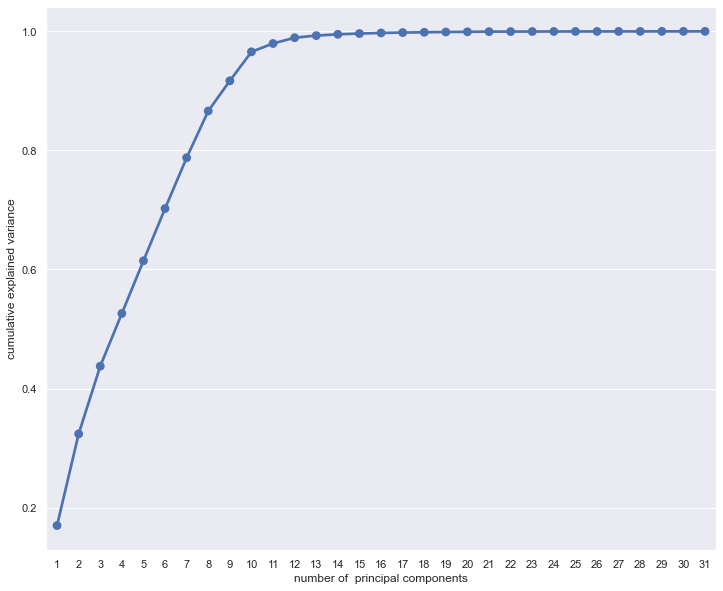

In [9]:
# Instantiate PCA without specifying number of components
pca_all = PCA()

# Fit to scaled data
pca_all.fit(X_train_scale)

# Save cumulative explained variance
cum_var = (np.cumsum(pca_all.explained_variance_ratio_))
n_comp = [i for i in range(1, pca_all.n_components_ + 1)]

# Plot cumulative variance
plt.figure(figsize=(12, 10))
ax = sns.pointplot(x=n_comp, y=cum_var)
ax.set(xlabel='number of  principal components', ylabel='cumulative explained variance')
plt.show()

With 10 components almost all of the variance in the original data is explained! That could signal that there are some highly correlated features in the original data.

Let's review these components.

In [11]:
# Instantiate PCA with 10 components
pca_10 = PCA(10)

# Fit to scaled data
pca_10.fit(X_train_scale)

# Transform scaled data
data_pc_10 = pca_10.transform(X_train_scale)

# Preview data
print(data_pc_10)

[[ 1.55125250e+00 -1.15633862e+00  8.31089239e-01 ... -2.11907934e-01
   4.41217991e-01 -2.35863765e-01]
 [-7.55346990e-01  2.43588325e-01 -3.59568815e-01 ...  4.20159476e-02
   5.95281791e-01 -3.81641123e-01]
 [-7.13128991e-01 -4.27611523e-01  2.15764143e-01 ...  4.01638117e-02
  -2.14240827e-01  7.42430664e-02]
 ...
 [ 1.09701745e-03 -7.68692250e-01  4.43373410e-01 ...  2.09335779e-03
  -4.64782572e-01  2.06482311e-01]
 [-5.09565219e-01  4.56218404e-01 -7.04657824e-01 ...  3.02863854e-01
  -8.88259821e-02 -4.57949601e-02]
 [-5.58040297e-01 -1.14317602e-01 -7.06582127e-02 ...  3.33632141e-02
   2.04038252e-01 -1.64858840e-01]]


## Wrapper Methods

Wrapper methods use a model to measure the effectiveness of a particular subset of features. One approach is to remove or add features sequentially. You can either start with 1 feature and gradually add until no improvement is made (forward selection), or do the reverse (backward selection). That can be done with the [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector) class which uses k-fold cross validation scores to decide which features to add or remove. [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) is similar to backwards elimination but uses feature importance scores to prune the number of features. You can also specify how many features to remove at each iteration of the recursion. Let's use this as the wrapper for our model below.

### Recursive Feature Elimination

Let's use the **RandomForestClassifier** as the model algorithm for which features should be selected. We will use **Recursive Feature Elimination**, which wraps around the selected model to perform feature selection.

In [24]:
# Down-sample data to increase speed of computations
FRAC = 0.2
X_train_scale_ds = X_train_scale.sample(frac=FRAC, random_state=42)
Y_train_ds = Y_train.sample(frac=FRAC, random_state=42)
X_test_scale_ds = X_test_scale.sample(frac=FRAC, random_state=42)
Y_test_ds = Y_test.sample(frac=FRAC, random_state=42)

# Calculate class weights for imbalanced data
pos = sum(Y_train_ds == 1)
neg = sum(Y_train_ds == 0)
total = len(Y_train_ds)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
class_weights = {0: (1 / neg) * (total / 2.0),
                 1: (1 / pos) * (total / 2.0)}

print(f'Class weights: \n{class_weights}')

rfe_model = RandomForestClassifier(criterion='entropy',
                                   random_state=42,
                                   class_weight=class_weights)

display_df = pd.DataFrame()
feat_names_res = {}

for i in range(5, X_train_scale_ds.shape[1] + 1, 5):
    print(f'Calculating RFE for {i} most important features...')
    
    # Wrap RFE around the model
    rfe = RFE(rfe_model, n_features_to_select=i)
    
    # Fit RFE
    rfe = rfe.fit(X_train_scale_ds, Y_train_ds)
    
    # Extract features
    feature_names = X_train_scale_ds.columns[rfe.get_support()]
    feat_names_res[i] = list(feature_names)
    
    # Fit model
    model = RandomForestClassifier(criterion='entropy',
                                   random_state=42,
                                   class_weight=class_weights)
    
    model.fit(X_train_scale_ds[feature_names], Y_train_ds)
    
    y_pred = model.predict(X_test_scale_ds[feature_names])
    
    # Error metrics
    acc = accuracy_score(Y_test_ds, y_pred)
    roc = roc_auc_score(Y_test_ds, y_pred)
    prec = precision_score(Y_test_ds, y_pred)
    rec = recall_score(Y_test_ds, y_pred)
    f1 = f1_score(Y_test_ds, y_pred)
    
    res = [acc, roc, prec, rec, f1,
           X_train_scale_ds[feature_names].shape[1]]
    cols = ['accuracy',
            'roc',
            'precision',
            'recall',
            'f1',
            'feature_count']
    
    # Append results
    if i == 1:
        display_df = pd.DataFrame([res], columns=cols)
    else:
        res_df = pd.DataFrame([res], columns=cols)
        display_df = display_df.append(res_df)

Class weights: 
{0: 0.5075447750669864, 1: 33.63551401869159}
Calculating RFE for 5 most important features...


/Users/viktor.eriksson2/Documents/stash/private/tfx-example-pipeline/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Calculating RFE for 10 most important features...
Calculating RFE for 15 most important features...
Calculating RFE for 20 most important features...
Calculating RFE for 25 most important features...
Calculating RFE for 30 most important features...


Nr of most performant features: 30
Best features: ['account_days_in_dc_12_24m', 'account_days_in_rem_12_24m', 'account_days_in_term_12_24m', 'avg_payment_span_0_12m', 'avg_payment_span_0_3m', 'max_paid_inv_0_12m', 'max_paid_inv_0_24m', 'num_active_div_by_paid_inv_0_12m', 'num_arch_written_off_0_12m', 'time_hours', 'account_amount_added_12_24m', 'age', 'has_paid', 'num_active_inv', 'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m', 'num_arch_ok_12_24m', 'num_arch_rem_0_12m', 'num_unpaid_bills', 'status_last_archived_0_24m', 'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months', 'status_max_archived_0_12_months', 'status_max_archived_0_24_months', 'recovery_debt', 'sum_capital_paid_account_0_12m', 'sum_capital_paid_account_12_24m', 'sum_paid_inv_0_12m']


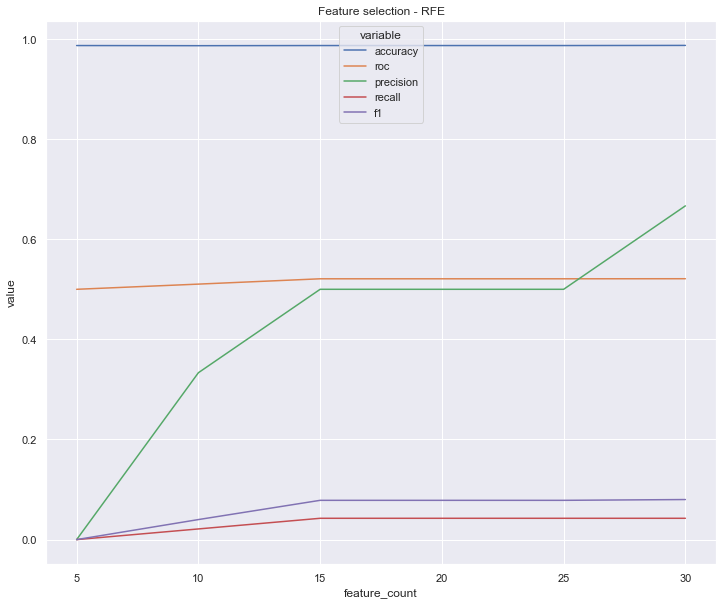

In [25]:
# Plot results
plt.figure(figsize=(12, 10))
sns.lineplot(x='feature_count',
             y='value',
             hue='variable',
             data=display_df.reset_index(drop=True).melt(
                 id_vars='feature_count'))
plt.title('Feature selection - RFE')

# Select best features
nr_feat = display_df.loc[display_df['f1'] == max(display_df['f1']),
                         'feature_count'].values[0]

best_features = feat_names_res[nr_feat]

print(f'Nr of most performant features: {nr_feat}')
print(f'Best features: {best_features}')

## Wrap up

So this process would decrease our nr of features that could be fed to our model for training, reducing required resources and optimizing for inference.